# Benign-Malignant Prediction

## Predict whether a mammogram mass is benign or malignant

I'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Aim and Approach

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* A Neural Network

## Prepare Data

Importing the mammographic_masses.data.txt file into a Pandas dataframe and take a look at it. Using the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [1]:
import pandas as pd

masses_data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; a model is only as good as the data it's given.

In [2]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. So, we drop every row that's missing data. If there appears to be any sort of correlation to what sort of data has missing fields, we will come back and fill that data in.

In [3]:
masses_data.loc[(masses_data['age'].isnull()) |
              (masses_data['shape'].isnull()) |
              (masses_data['margin'].isnull()) |
              (masses_data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


The missing data seems randomly distributed, so go ahead and drop rows with missing data.

In [4]:
masses_data.dropna(inplace=True)
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


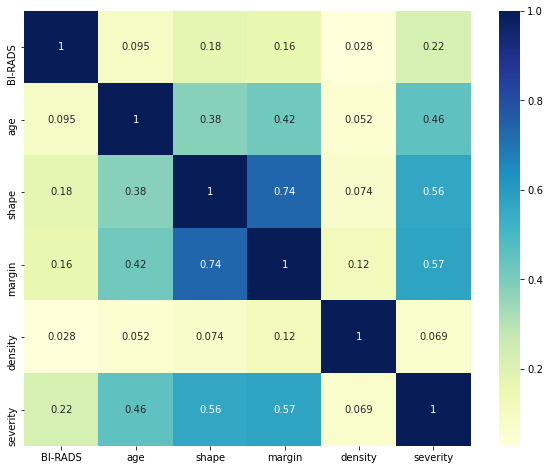

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(masses_data.corr(), annot=True, cmap='YlGnBu');

Convert the Pandas dataframes into numpy arrays that can be used by scikit_learn.

In [6]:
all_features = masses_data[['age', 'shape', 'margin', 'density']].values

all_classes = masses_data['severity'].values

feature_names = ['age', 'shape', 'margin', 'density']

all_features

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Normalize the attribute data, since some of the models require the input data to be normalized.

In [7]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
all_features_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

In [8]:
# Spliting the data into Training Data and Testing Data

import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1234)

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_features_scaled, all_classes, train_size=0.75, random_state=1)

## Decision Trees

Before moving to K-Fold cross validation and Random Forests, start by creating a single train/test split of our data.

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf= DecisionTreeClassifier(random_state=1)

# Train the classifier on the training set
clf.fit(training_inputs, training_classes)

DecisionTreeClassifier(random_state=1)

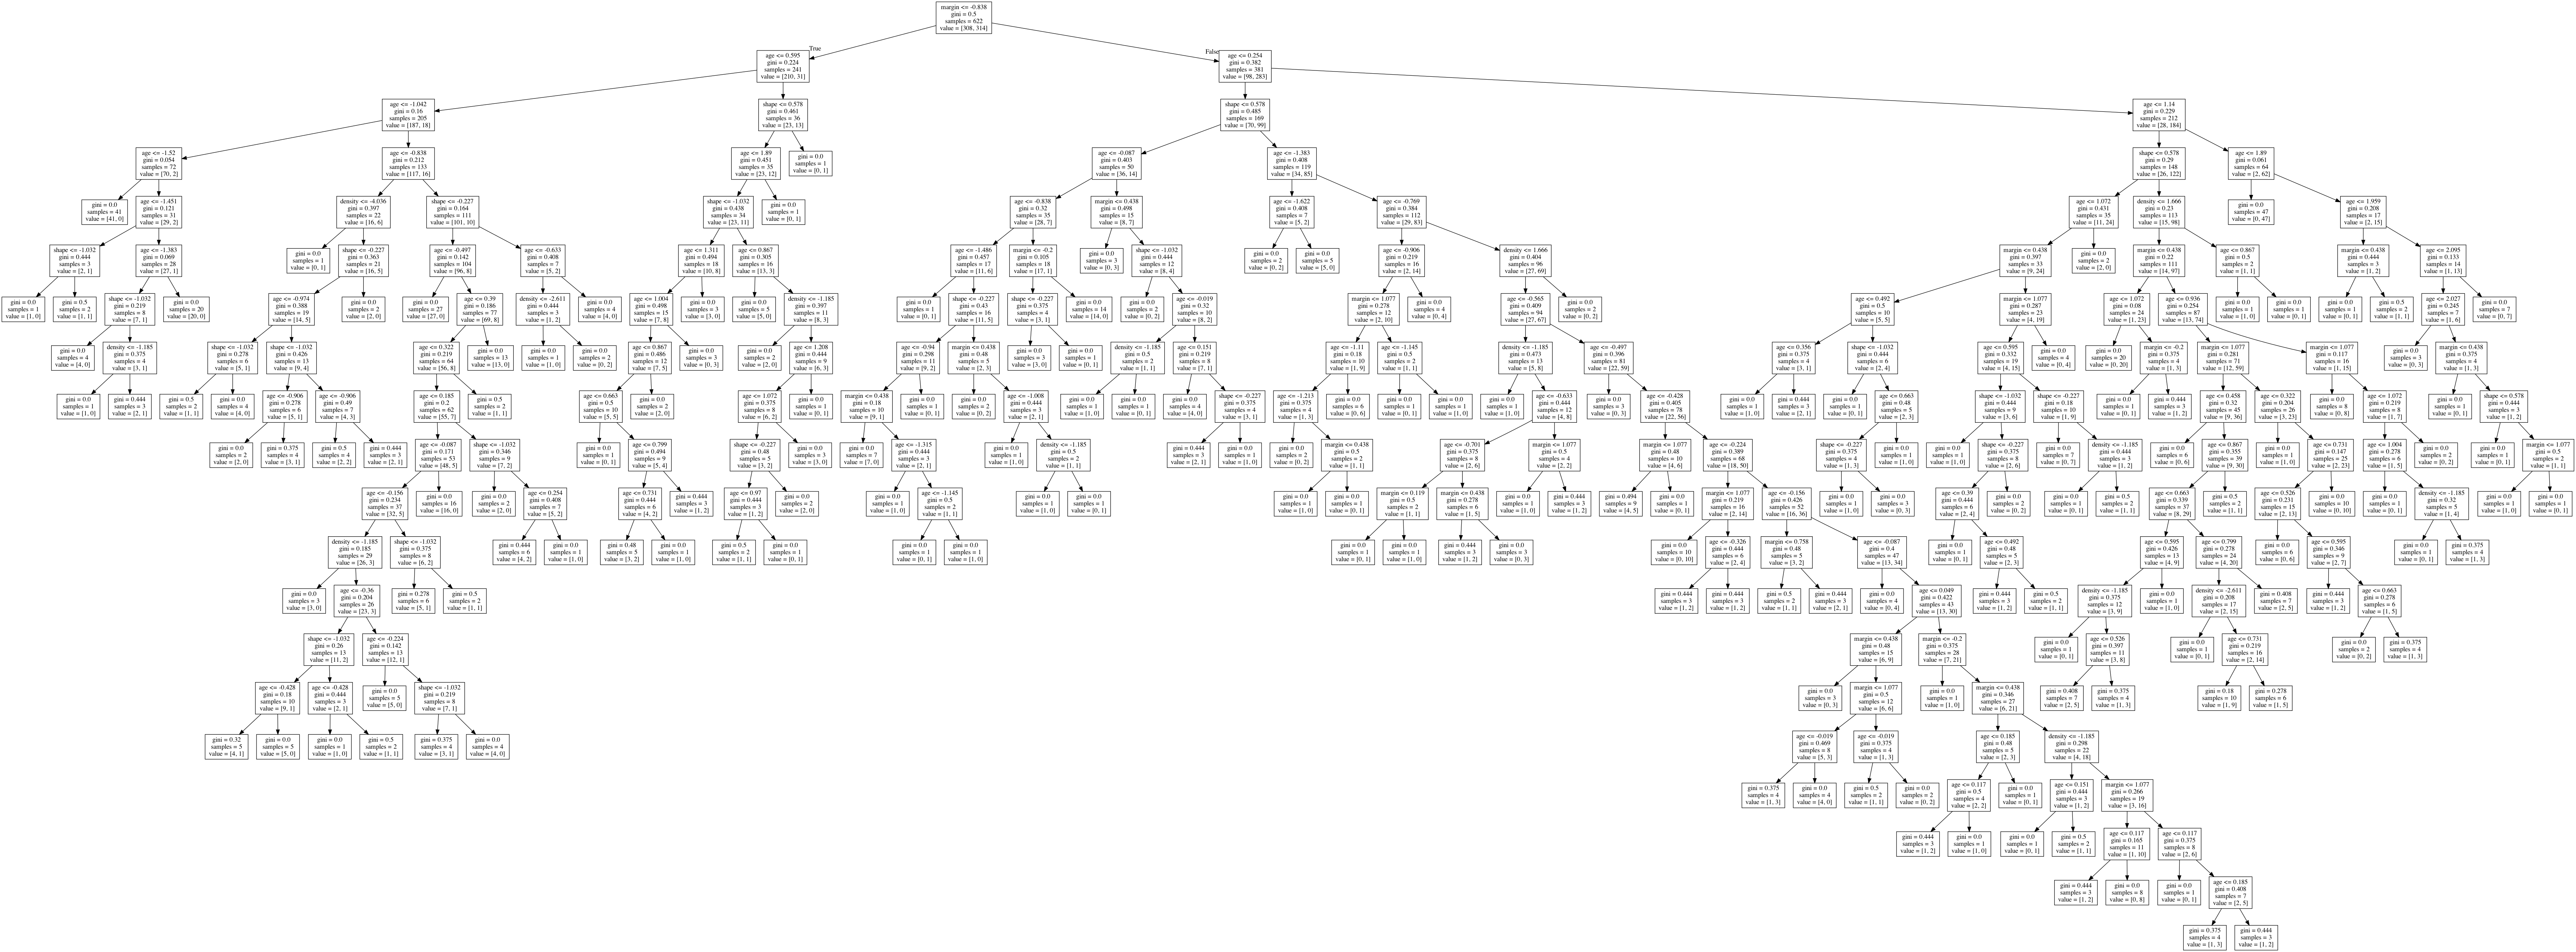

In [10]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

Measure the accuracy of the resulting decision tree model using your test data.

In [11]:
clf.score(testing_inputs, testing_classes)

0.7355769230769231

### K-Fold Cross Validation

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10).

In [12]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=1)

cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7373493975903613

### Random Forest

Now try a RandomForestClassifier.

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=1)
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)

cv_scores.mean()

0.7421686746987952

## SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the linear, rbf, sigmoid and poly kernels and see what the best-performing kernel is.

In [14]:
from sklearn import svm
C = 1.0

import warnings
warnings.filterwarnings('ignore')

In [15]:
svc = svm.SVC(kernel='linear', C=C, gamma="auto")
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.7975903614457832

In [16]:
svc = svm.SVC(kernel='rbf', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.8012048192771084

In [17]:
svc = svm.SVC(kernel='sigmoid', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.7457831325301204

In [18]:
svc = svm.SVC(kernel='poly', C=C)
cv_scores = cross_val_score(svc, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.7903614457831326

## KNN
K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set. Choosing K is tricky. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [19]:
from sklearn import neighbors
for n in range(1, 50):
    clf = neighbors.KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
    print (n, cv_scores.mean())

1 0.7325301204819278
2 0.6903614457831325
3 0.7542168674698796
4 0.7349397590361446
5 0.7710843373493976
6 0.7686746987951807
7 0.7951807228915662
8 0.7771084337349398
9 0.7903614457831326
10 0.7915662650602409
11 0.7891566265060241
12 0.783132530120482
13 0.7879518072289157
14 0.7867469879518072
15 0.7867469879518072
16 0.7831325301204819
17 0.7783132530120482
18 0.7783132530120482
19 0.7843373493975904
20 0.7855421686746988
21 0.7879518072289156
22 0.7855421686746988
23 0.7783132530120481
24 0.7783132530120482
25 0.7867469879518072
26 0.7855421686746988
27 0.7855421686746988
28 0.7867469879518072
29 0.7855421686746988
30 0.7903614457831325
31 0.7867469879518072
32 0.789156626506024
33 0.7879518072289156
34 0.7867469879518072
35 0.7831325301204819
36 0.7867469879518072
37 0.7843373493975904
38 0.7867469879518072
39 0.7819277108433734
40 0.7843373493975904
41 0.780722891566265
42 0.7819277108433734
43 0.780722891566265
44 0.7819277108433734
45 0.7831325301204819
46 0.7843373493975904
4

## Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(all_features)

clf = MultinomialNB()
cv_scores = cross_val_score(clf, all_features_minmax, all_classes, cv=10)

cv_scores.mean()

0.7855421686746988

## Logistic Regression

Fundamentally this is just a binary classification problem. Logisitic Regression is a simple way to tackling this sort of thing.

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
cv_scores = cross_val_score(clf, all_features_scaled, all_classes, cv=10)
cv_scores.mean()

0.8072289156626505

## Neural Networks

In [24]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=create_model, epochs=25, verbose=0)
cv_scores = cross_val_score(estimator, all_features_scaled, all_classes, cv=10)
cv_scores

array([0.73493975, 0.78313255, 0.87951809, 0.81927711, 0.81927711,
       0.73493975, 0.75903612, 0.85542166, 0.89156628, 0.78313255])

In [26]:
cv_scores.mean()

0.8060240983963013